<a href="https://colab.research.google.com/github/Jectrianama/Datasets_biplot/blob/main/AM_Analisis_arroz_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Relevance Analysis RiceCropData Cycle1

---A vegetation index is a mathematical formula used to quantify the amount and health of vegetation in a given area. These indices are calculated based on the spectral properties of light that plants absorb and reflect.---<!-- ![picture](https://raw.githubusercontent.com/Jectrianama/images-PhD_jenn/main/.github/workflows/variables.png) --><img src="https://github.com/Jectrianama/images-PhD_jenn/blob/main/.github/workflows/variables.png?raw=true:, width=700" alt="My Image" width=700><img src="https://github.com/Jectrianama/images-PhD_jenn/blob/main/.github/workflows/vuelos.png?raw=true:, width=250" alt="My Image" width=250>Analysis for agronomical and remote sensing  data from Tolima Rice Crop

## Rice database cycle 1 and 2

In [ ]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        if normalize:
            title = 'Matriz de confusión normalizada'
        else:
            title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize='true')
    # se identifican las etiquetas en los datos
    #classes = classes[unique_labels(y_true, y_pred)]
    #if normalize:
    #    cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
import joblib
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
import pandas as pd

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial.distance import cdist

def Kcen(K):
  n = K.shape[0]
  I_n = np.eye(n)
  one_n = np.ones((n,1))
  term_1 = I_n
  term_2 = (1 / n) * np.dot(one_n, one_n.T)
  H = term_1 - term_2
  return (H.dot(K)).dot(H)

def apply_Kernel(Xdata):
    scaler = MinMaxScaler() #StandardScaler()

    scaler.fit(Xdata)

    Xdata_scaled = scaler.transform(Xdata)
    Xdata_scaled = Xdata_scaled + 0.005 #ofset porque despues del minmax tambn tenemos datos en ceros
    X_hat = Xdata_scaled
    Dq = cdist(X_hat.T,X_hat.T)
    sigma_Q = np.median(squareform(Dq))#0.1 o 0.01
    # K_Q -> P x P
    K_Q = rbf_kernel(X_hat.T, gamma = 1/ (sigma_Q**2))
    K_Q = Kcen(K_Q)

    df_K_Q = pd.DataFrame(K_Q, index= Xdata.columns, columns= Xdata.columns)

    return df_K_Q

In [3]:
! cat /root/.ssh/id_rsa

cat: /root/.ssh/id_rsa: No such file or directory


In [4]:
!wget http://github.com/Jectrianama/Datasets_biplot/DATA_C1_C2IMP.zip
! mkdir -p /root/.ssh
with open("/root/.ssh/id_rsa", mode="w") as fp:
    fp.write("""<private key>""")
! ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
! chmod go-rwx /root/.ssh/id_rsa
! git clone git@github.com:Jectrianama/Datasets_biplot.git
%cd /content/Datasets_biplot

URL transformed to HTTPS due to an HSTS policy
--2024-02-13 14:42:37--  https://github.com/Jectrianama/Datasets_biplot/DATA_C1_C2IMP.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-02-13 14:42:37 ERROR 404: Not Found.

# github.com:22 SSH-2.0-babeld-57ca1323
Cloning into 'Datasets_biplot'...
Load key "/root/.ssh/id_rsa": error in libcrypto
git@github.com: Permission denied (publickey).
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
[Errno 2] No such file or directory: '/content/Datasets_biplot'
/content


In [ ]:
#Yield Data
#https://drive.google.com/file/d/1y38d32EIzMRKMk_fXho2Sb4lgnw7HLh_/view?usp=sharing

#cargar datos desde drive acceso libre
FILEID = "1y38d32EIzMRKMk_fXho2Sb4lgnw7HLh_"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O  yield_4.zip && rm -rf /tmp/cookies.txt
!unzip -o yield_4.zip
!dir

--2023-10-13 16:34:26--  https://docs.google.com/uc?export=download&confirm=&id=1y38d32EIzMRKMk_fXho2Sb4lgnw7HLh_
Resolving docs.google.com (docs.google.com)... 74.125.69.100, 74.125.69.139, 74.125.69.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.69.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ehr9v1nk24s8m9qdn95vm1qtct93bgsd/1697214825000/07591141114418430227/*/1y38d32EIzMRKMk_fXho2Sb4lgnw7HLh_?e=download&uuid=0b504ce5-8a81-4e06-a5cb-ddb6cb9f47a4 [following]
--2023-10-13 16:34:27--  https://doc-10-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ehr9v1nk24s8m9qdn95vm1qtct93bgsd/1697214825000/07591141114418430227/*/1y38d32EIzMRKMk_fXho2Sb4lgnw7HLh_?e=download&uuid=0b504ce5-8a81-4e06-a5cb-ddb6cb9f47a4
Resolving doc-10-90-docs.googleusercontent.com (doc-10-90-docs.googleusercontent.com)... 173.194.74.132, 2607:

In [ ]:
#data downloaded for google drive
#https://drive.google.com/file/d/1oOWI2plwBxLXdZjNWkO5TOefalUsDfVE/view?usp=sharing #campa 1 y 2 actualizada 2023 SIN IMPUTAR
'''
sin variables aquacrop
FILEID = "1GbBBtycT-U1UDKrzpcxbJpMZyKQeDBBN"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O DATA_C1_C2IMP.zip && rm -rf /tmp/cookies.txt
!unzip -o DATA_C1_C2IMP.zip #DATA_C1_C2_2023.zip Sin imputar
!dir
'''
#cargar datos desde drive acceso libre
FILEID = "1pt33hwfKKZcjztGh4BMmz7ksXbKYtb8o"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O  Data_Aquacrop.zip && rm -rf /tmp/cookies.txt
!unzip -o Data_Aquacrop.zip
!dir

--2023-10-13 16:34:28--  https://docs.google.com/uc?export=download&confirm=&id=1pt33hwfKKZcjztGh4BMmz7ksXbKYtb8o
Resolving docs.google.com (docs.google.com)... 74.125.69.100, 74.125.69.139, 74.125.69.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.69.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ir8gjc88ll7ond7ua40hdh3s9c9gms55/1697214825000/07591141114418430227/*/1pt33hwfKKZcjztGh4BMmz7ksXbKYtb8o?e=download&uuid=8ee27e5e-e9a1-4715-9839-411d21e30c42 [following]
--2023-10-13 16:34:29--  https://doc-14-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ir8gjc88ll7ond7ua40hdh3s9c9gms55/1697214825000/07591141114418430227/*/1pt33hwfKKZcjztGh4BMmz7ksXbKYtb8o?e=download&uuid=8ee27e5e-e9a1-4715-9839-411d21e30c42
Resolving doc-14-90-docs.googleusercontent.com (doc-14-90-docs.googleusercontent.com)... 173.194.74.132, 2607:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import os
warnings.filterwarnings("ignore")

#process libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
warnings.filterwarnings("ignore")
os.environ['PATH'] = os.environ['PATH'] + ':/usr/texbin'


# %matplotlib inline
# #csv_path = '/content/DATA_C1_C2_actual.xlsx' #database directory on collaborative disk according to prevously uploaded file
# csv_path = '/content/DATA_C1_C2_actualImputed.xlsx'
# Xdata = pd.read_excel(csv_path) #read csv file


%matplotlib inline
csv_path = '/content/aquacrop_out_Final_Imp.csv' #database directory on collaborative disk according to prevously uploaded file

Xdata = pd.read_csv(csv_path) #read csv file

In [ ]:

yield_path = '/content/Output_measured_yield.csv' #database directory on collaborative disk according to prevously uploaded file

Yield_data = pd.read_csv(yield_path) #read csv file

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# #drive.mount('/content/drive')
# filename =  "/content/drive/Shareddrives/GCPDS/Arroz/index_relevance/results_df"

# loaded_results_df= joblib.load(filename+".pkl",'rb')

In [ ]:
cicle1Y = Yield_data[Yield_data['Cycle'] == 1]
n = 7
yield_C1 = pd.concat([cicle1Y ['Yield']] * (n+1), axis=0, ignore_index=True)
yield_C1

cicle2Y = Yield_data[Yield_data['Cycle'] == 2]
n = 7
yield_C2 = pd.concat([cicle2Y ['Yield']] * (n+1), axis=0, ignore_index=True)
yield_C1
yieldall = pd.concat([yield_C1, yield_C2])

In [ ]:
yieldall

0       7.970753
1      10.299338
2       7.826339
3       8.729167
4       6.746405
         ...    
379     7.472185
380     7.564148
381     6.398089
382     5.528990
383     7.612708
Name: Yield, Length: 768, dtype: float64

removemos las columnas que no se van a incluir en el modelo

In [ ]:
Xdata.drop(columns= ['Unnamed: 0', 'LWIR', 'CWSI', 'Tmin.y', 'Tavg', 'Tmax.y', 'CO2', 'WC1.vol..',
       'WC2.vol..', 'WC3.vol..', 'WC4.vol..', 'WC5.vol..', 'WC6.vol..','WC7.vol..', 'Rainfall', 'ETo',
       'Tmax.x', 'Tmin.x', 'Tprom', 'Rad', 'RH', 'WV', 'WC8.vol..', 'WC9.vol..', 'WC10.vol..', 'WC11.vol..', 'WC12.vol..', 'GD', 'Z', 'CC', 'CCw', 'Kc.Tr.', 'Trx', 'Tr', 'TrW',
       'Tr.Trx', 'WP', 'Biomass', 'YieldPart', 'Brelative', 'WPet','Eto' ], inplace=True)#

In [ ]:
Xdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Cycle             768 non-null    int64  
 1   Date              768 non-null    int64  
 2   Treatment         768 non-null    object 
 3   Blue              768 non-null    float64
 4   Green             768 non-null    float64
 5   Red               768 non-null    float64
 6   Red_Edge          768 non-null    float64
 7   NIR               768 non-null    float64
 8   NDRE              768 non-null    float64
 9   GNDVI             768 non-null    float64
 10  GVI               768 non-null    float64
 11  NDVI              768 non-null    float64
 12  OSAVI             768 non-null    float64
 13  SAVI              768 non-null    float64
 14  SR                768 non-null    float64
 15  ExG               768 non-null    float64
 16  GA                768 non-null    float64
 1

In [ ]:
Xdata = Xdata.dropna().reset_index(drop=True)

In [ ]:
Xdata.describe()

,Cycle,Date,Blue,Green,Red,Red_Edge,NIR,NDRE,GNDVI,GVI,...,LWP_pd,LWP_md,CRC_SPAD,Pn,Gs,Ci,E,eWUE,iWUE,Dry_biomass
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,...,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,1.500000,4.500000,0.022648,0.063211,0.026056,0.131149,0.370565,0.473464,0.705318,6.540315,...,-0.275521,-1.778906,34.620052,20.890104,0.478860,241.664659,6.832905,3.020730,52.411604,9.429023
std,0.500326,2.292781,0.007811,0.019990,0.011745,0.039112,0.115236,0.093546,0.078972,1.797205,...,0.272422,0.211687,5.143238,6.360735,0.246777,28.256925,1.831089,0.729884,16.569400,6.150172
min,1.000000,1.000000,0.002411,0.006174,0.001603,0.013485,0.042426,0.170310,0.397805,2.362876,...,-1.950000,-2.250000,18.500000,0.532899,0.028678,159.342964,1.068218,0.498867,9.189924,0.532752
25%,1.000000,2.750000,0.018425,0.056436,0.019097,0.118235,0.335360,0.422811,0.664908,5.399645,...,-0.300000,-1.950000,31.600000,16.202375,0.297559,222.500925,5.627644,2.503882,41.567560,4.152712
50%,1.500000,4.500000,0.021585,0.063661,0.024409,0.136057,0.400123,0.491035,0.724431,6.561845,...,-0.200000,-1.800000,35.000000,21.071334,0.456225,238.338650,6.595751,2.914824,49.921340,9.185520
75%,2.000000,6.250000,0.028787,0.072256,0.032157,0.150884,0.437023,0.541863,0.761892,7.780760,...,-0.150000,-1.650000,38.300000,25.483451,0.590492,257.727950,7.983417,3.507542,61.323671,13.962400
max,2.000000,8.000000,0.049870,0.112728,0.064238,0.234228,0.626118,0.665569,0.836549,11.660978,...,-0.050000,-0.930000,47.400000,37.349730,2.171564,345.111500,12.863071,5.540621,125.921826,25.822400


In [ ]:
mapping = {

    1: "T1",
    2: "T2",
    3: "T3",
    4: "T4",
    5: "T5",
    6: "T6",
    7: "T7",
    8: "T8",
}

Xdata['Date'].replace(mapping, inplace=True)

añadimos la columna  etapas (stage)

In [ ]:
def get_stages(date):
    if date < 'T3':
        return 'vegetative'
    elif date >= 'T3' and date < 'T6':
        return 'reproductive'
    else:
        return 'rippening'

Xdata.insert(2,'Stage','')
Xdata['Stage'] = Xdata['Date'].apply(get_stages)

convertimos las variables categoricas a  numericas

In [ ]:
Xdata

,Cycle,Date,Stage,Treatment,Blue,Green,Red,Red_Edge,NIR,NDRE,...,LWP_pd,LWP_md,CRC_SPAD,Pn,Gs,Ci,E,eWUE,iWUE,Dry_biomass
0,1,T1,vegetative,MIRI,0.026750,0.071852,0.032586,0.133489,0.298622,0.367714,...,-0.30,-1.95,26.0,20.199060,0.439376,275.744800,5.378013,3.755860,45.972110,1.011518
1,1,T1,vegetative,MIRI,0.028773,0.073954,0.035688,0.135127,0.282962,0.342890,...,-0.30,-2.05,35.6,28.557910,0.835768,293.555900,8.226924,3.471275,34.169680,0.986870
2,1,T1,vegetative,MIRI,0.026983,0.072969,0.032669,0.136991,0.297315,0.357813,...,-0.40,-1.80,25.6,17.914900,0.473243,285.549500,4.493475,3.986869,37.855560,1.609007
3,1,T1,vegetative,MIRI,0.027776,0.073456,0.033839,0.137247,0.301064,0.358873,...,-0.35,-1.75,26.2,25.352840,0.623879,276.458300,6.772962,3.743243,40.637400,1.029292
4,1,T1,vegetative,MIRI,0.027969,0.071821,0.034336,0.132628,0.275728,0.338675,...,-0.30,-1.55,32.1,22.787940,0.377381,245.120900,6.489473,3.511524,60.384410,1.163228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,2,T8,rippening,CONTROL,0.037596,0.092363,0.050045,0.186811,0.415244,0.390847,...,-0.20,-1.70,32.8,29.992991,0.696125,220.156800,8.625706,3.908401,44.167280,5.696000
764,2,T8,rippening,CONTROL,0.035831,0.095941,0.043091,0.190684,0.460858,0.417191,...,-0.25,-1.65,27.4,16.161681,0.766169,213.888800,6.364068,2.645047,49.918750,5.120000
765,2,T8,rippening,CONTROL,0.037295,0.099716,0.046837,0.207717,0.527661,0.435119,...,-0.20,-2.05,32.3,18.392707,0.628051,237.937172,7.154743,2.827074,39.164999,5.168000
766,2,T8,rippening,CONTROL,0.038131,0.101158,0.051661,0.216974,0.534129,0.423493,...,-0.35,-1.95,34.6,15.297240,0.473709,218.203200,6.184005,2.634019,52.812843,7.520000


In [ ]:
Xdata['Yield'] = yieldall.values
Xdata

,Cycle,Date,Stage,Treatment,Blue,Green,Red,Red_Edge,NIR,NDRE,...,LWP_md,CRC_SPAD,Pn,Gs,Ci,E,eWUE,iWUE,Dry_biomass,Yield
0,1,T1,vegetative,MIRI,0.026750,0.071852,0.032586,0.133489,0.298622,0.367714,...,-1.95,26.0,20.199060,0.439376,275.744800,5.378013,3.755860,45.972110,1.011518,7.970753
1,1,T1,vegetative,MIRI,0.028773,0.073954,0.035688,0.135127,0.282962,0.342890,...,-2.05,35.6,28.557910,0.835768,293.555900,8.226924,3.471275,34.169680,0.986870,10.299338
2,1,T1,vegetative,MIRI,0.026983,0.072969,0.032669,0.136991,0.297315,0.357813,...,-1.80,25.6,17.914900,0.473243,285.549500,4.493475,3.986869,37.855560,1.609007,7.826339
3,1,T1,vegetative,MIRI,0.027776,0.073456,0.033839,0.137247,0.301064,0.358873,...,-1.75,26.2,25.352840,0.623879,276.458300,6.772962,3.743243,40.637400,1.029292,8.729167
4,1,T1,vegetative,MIRI,0.027969,0.071821,0.034336,0.132628,0.275728,0.338675,...,-1.55,32.1,22.787940,0.377381,245.120900,6.489473,3.511524,60.384410,1.163228,6.746405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,2,T8,rippening,CONTROL,0.037596,0.092363,0.050045,0.186811,0.415244,0.390847,...,-1.70,32.8,29.992991,0.696125,220.156800,8.625706,3.908401,44.167280,5.696000,7.472185
764,2,T8,rippening,CONTROL,0.035831,0.095941,0.043091,0.190684,0.460858,0.417191,...,-1.65,27.4,16.161681,0.766169,213.888800,6.364068,2.645047,49.918750,5.120000,7.564148
765,2,T8,rippening,CONTROL,0.037295,0.099716,0.046837,0.207717,0.527661,0.435119,...,-2.05,32.3,18.392707,0.628051,237.937172,7.154743,2.827074,39.164999,5.168000,6.398089
766,2,T8,rippening,CONTROL,0.038131,0.101158,0.051661,0.216974,0.534129,0.423493,...,-1.95,34.6,15.297240,0.473709,218.203200,6.184005,2.634019,52.812843,7.520000,5.528990


In [ ]:
#Xdata = Xdata[Xdata['Cycle'] == 1].reset_index(drop=True)
#Xdata = Xdata[Xdata['Stage'] == 'vegetative'].reset_index(drop=True)
# replacing values
Xdata['Treatment'].replace(['MIRI', 'AWD', 'CONTROL'],
                        [1, 2, 3], inplace=True)
Xdata['Date'].replace(["T1", "T2", "T3", "T4", "T5", "T6", "T7","T8"],
                        [ 1, 2,3, 4, 5, 6, 7, 8], inplace=True)
Xdata['Stage'].replace(["vegetative", "reproductive", "rippening"],
                        [ 1, 2,3], inplace=True)

<Axes: >

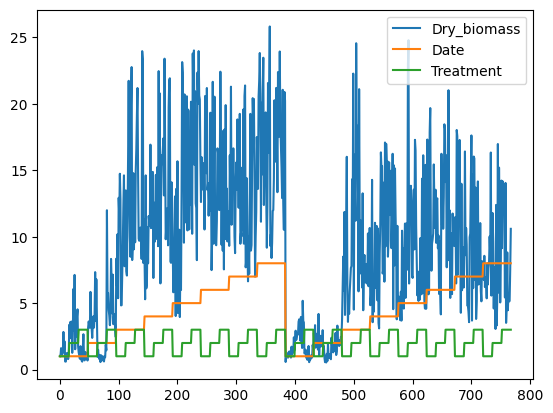

In [ ]:
Xdata[['Dry_biomass', 'Date', 'Treatment' ] ].plot()

#Xdata['Date'].plot()

#Xdata['Treatment'].plot()

seleccionamos las  variables que entraran al modelo

In [ ]:
#Xdata = Xdata[['Cycle', 'Date', 'Stage', 'Treatment', 'Blue', 'Green', 'Red', 'Red_Edge', 'NIR',
  #     'NDRE', 'GNDVI', 'GVI', 'NDVI', 'OSAVI', 'SAVI', 'SR', 'ExG', 'GA',
  #     'GGA', 'PRI', 'NDVI_Greenseeker', 'EWT', 'CWC_cept', 'CWC_cal', 'LWC',
  #     'Soil_moisture', 'LAI_cep', 'LAI_cal', 'Fv_Fm', 'NPQ', 'LWP_pd',
   #   'LWP_md', 'CRC_SPAD', 'Pn', 'Gs', 'Ci', 'E', 'eWUE', 'iWUE',
   #     'Dry_biomass']]

In [ ]:
#Xdata.describe()

In [ ]:
np.unique(Xdata['Date'].values)

array([1, 2, 3, 4, 5, 6, 7, 8])

#t-SNE todos los datos

In [ ]:
col_sal = ['Soil_moisture' , 'LWP_pd', 'LWP_md',  'CWC_cal',  'LAI_cep', 'LAI_cal', 'CWC_cept', 'LAI_cep']
#'Dry_biomass', 'Treatment', 'Date', 'Stage',
data=Xdata.copy()
data_ = data.copy()
#targets = data[col_sal]
#target = targets[['Dry_biomass']]
#data.drop(columns=col_sal,inplace=True)

mmax = MinMaxScaler()
mmax_ = MinMaxScaler()

red = TSNE(n_components=2, random_state=42, perplexity = 20)
#red = PCA(n_components=2, random_state=42)
zz = mmax_.fit_transform(red.fit_transform(mmax.fit_transform(data)))

In [ ]:
#data = pd.concat([data,Xdata[col_sal]], axis=1)
data['P1'] = zz[:,0]
data['P2'] = zz[:, 1]

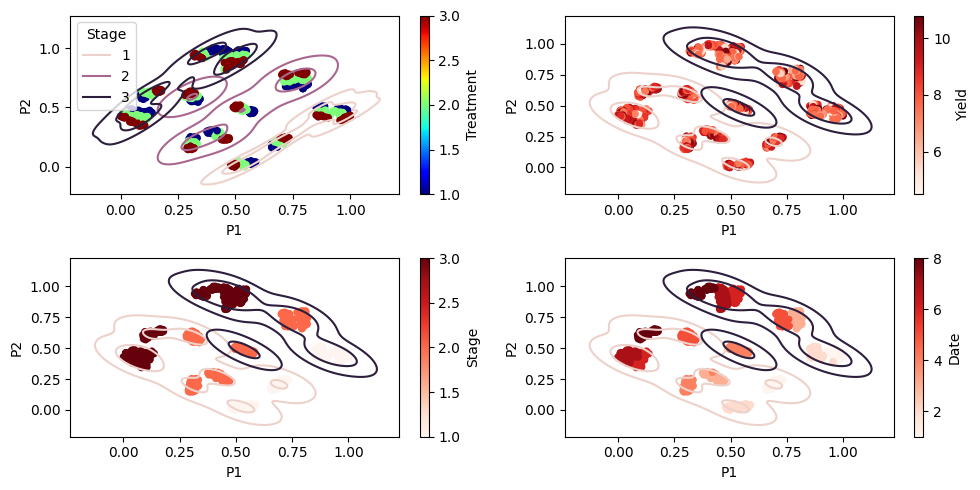

In [ ]:

from matplotlib import cm
from seaborn import kdeplot
#cmap_ = cm.Reds(range(len(np.unique(Xdata['Dry_biomass'].values))))
fig, ax = plt.subplots(2,2,figsize=(10,5))

#treatment
kdeplot(data=data, x='P1', y='P2',hue='Stage', ax=ax[0,0], levels=3)
data.plot(kind='scatter',x='P1',y='P2',ax=ax[0,0],c='Treatment',cmap='jet',legend=False)

#DryBiomass
kdeplot(data=data, x='P1', y='P2',
 hue='Cycle', ax=ax[0,1], levels=3,legend=False)
data.plot(kind='scatter',x='P1',y='P2',
 ax=ax[0,1],c='Yield',cmap='Reds',legend=False)


#Stage
kdeplot(data=data, x='P1', y='P2',
 hue='Cycle', ax=ax[1,0], levels=3,legend=False)
data.plot(kind='scatter',x='P1',y='P2',
 ax=ax[1,0],c='Stage',cmap='Reds',legend=False )


#Date
kdeplot(data=data, x='P1', y='P2',
 hue='Cycle', ax=ax[1,1], levels=3,legend=False)
data.plot(kind='scatter',x='P1',y='P2',
 ax=ax[1,1],c='Date',cmap='Reds',legend=False )

plt.subplots_adjust(wspace=0.25,hspace=0.25)
plt.tight_layout()

plt.savefig('tsnekde.png')
plt.show()

# Box plots Dry Biomass por fecha, tratamiento y ciclo

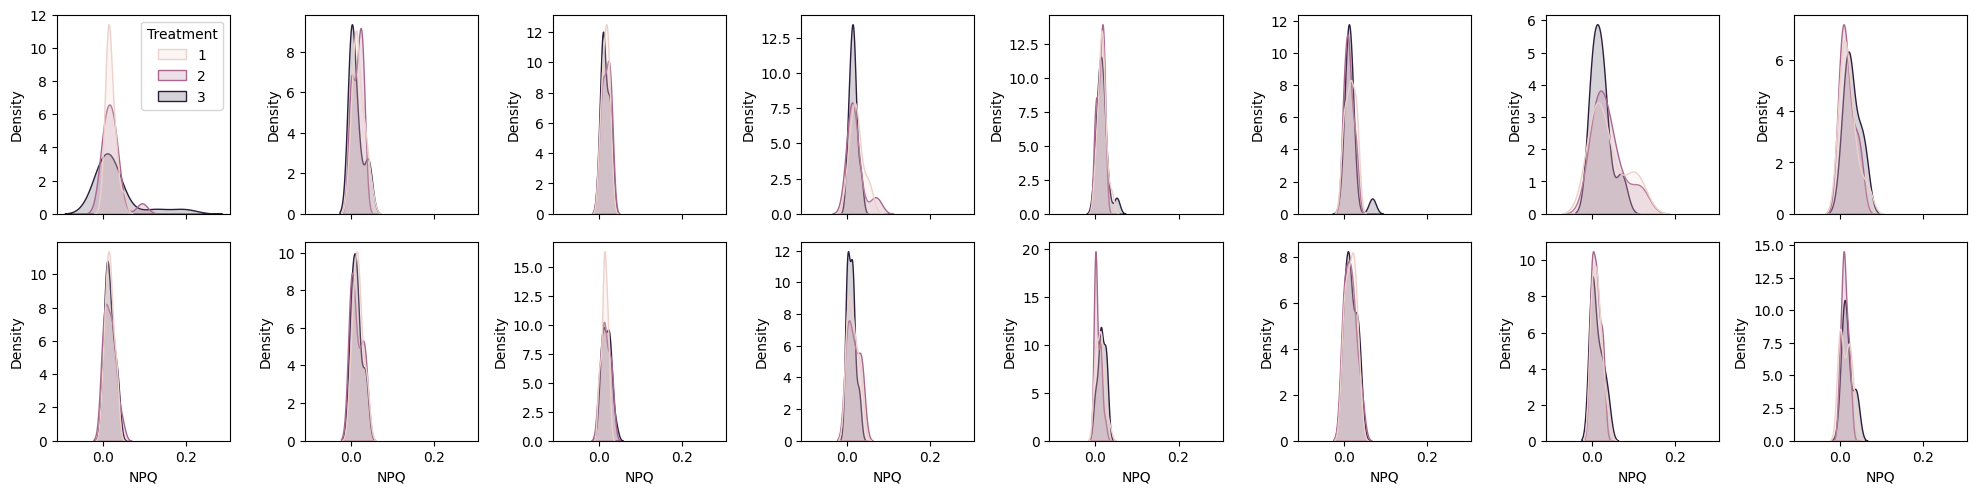

filas: Cycle - columnas: Date


In [ ]:

trows = 'Cycle' #target filas
rows = np.unique(data[trows])
tcols = 'Date' #target filas
cols = np.unique(data[tcols])
xcon = 'NPQ' #variable conteo
hue = 'Treatment' #condicional conteo
fig, axes = plt.subplots(nrows=len(rows) , ncols=len(cols),
                         sharey=False,sharex = True,figsize=(20,5)) # create 2x2 array of subplots
legend_ = True
for ic, jc in enumerate(rows):
   for id, jd in enumerate(cols):
        #data[(data[tcols] == jd) & (data[trows] == jc)].boxplot(column=hue,
                #  by=xcon, ax=axes[ic,id])
        kdeplot(data=data[(data[tcols] == jd) & (data[trows] == jc)],x=xcon,
                  hue=hue, ax=axes[ic,id],legend=legend_,fill=True,alpha=0.2,common_norm=True)
        if (ic == 0) & (id == 0): legend_ = False

plt.subplots_adjust(wspace=0.25,hspace=0.25)
plt.tight_layout()
plt.savefig('DryBioDateCycle.png')
plt.show()

print(f"filas: {trows} - columnas: {tcols}")

#Analisis Yield

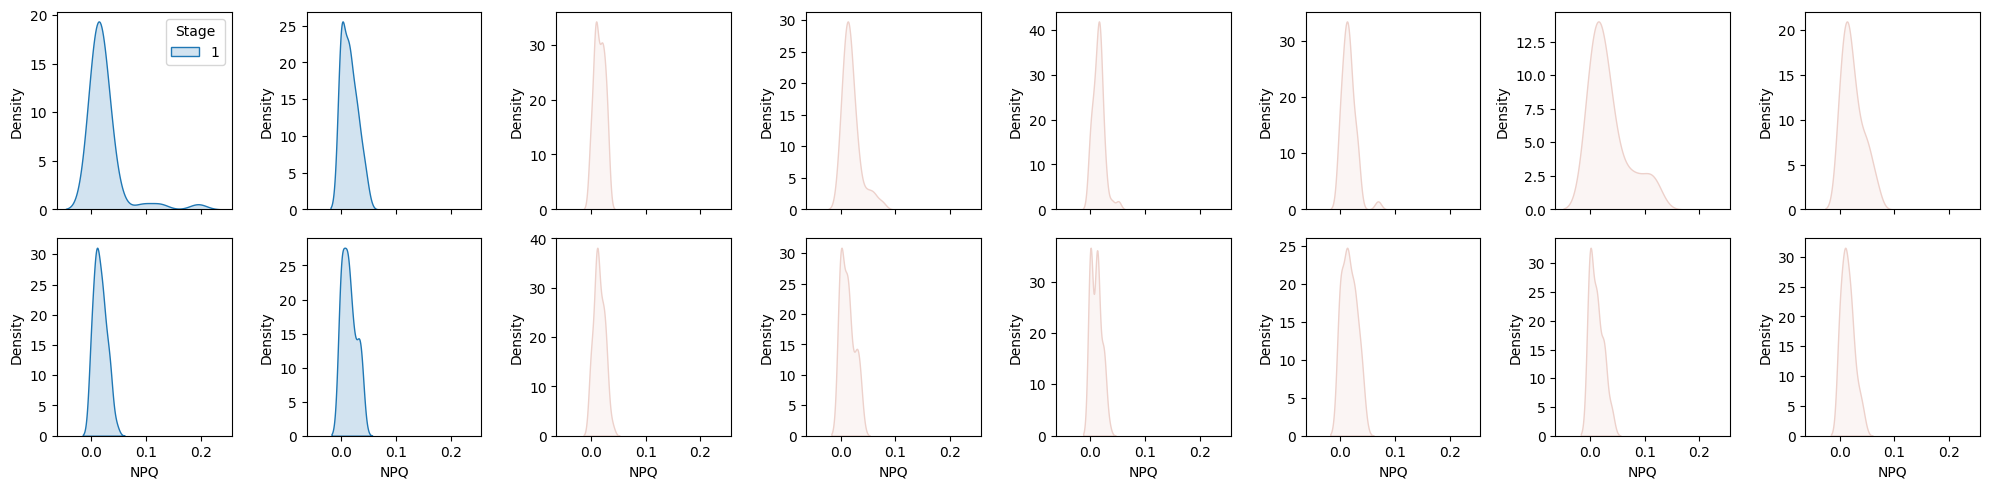

filas: Cycle - columnas: Date


In [ ]:

trows = 'Cycle' #target filas
rows = np.unique(data[trows])
tcols = 'Date' #target filas
cols = np.unique(data[tcols])
xcon = 'NPQ' #variable conteo
hue = 'Stage' #condicional conteo
fig, axes = plt.subplots(nrows=len(rows) , ncols=len(cols),
                         sharey=False,sharex = True,figsize=(20,5)) # create 2x2 array of subplots
legend_ = True
for ic, jc in enumerate(rows):
   for id, jd in enumerate(cols):
        #data[(data[tcols] == jd) & (data[trows] == jc)].boxplot(column=hue,
                #  by=xcon, ax=axes[ic,id])
        kdeplot(data=data[(data[tcols] == jd) & (data[trows] == jc)],x=xcon,
                  hue=hue, ax=axes[ic,id],legend=legend_,fill=True,alpha=0.2,common_norm=True)
        if (ic == 0) & (id == 0): legend_ = False

plt.subplots_adjust(wspace=0.25,hspace=0.25)
plt.tight_layout()
plt.savefig('DryBioDateCycle.png')
plt.show()

print(f"filas: {trows} - columnas: {tcols}")

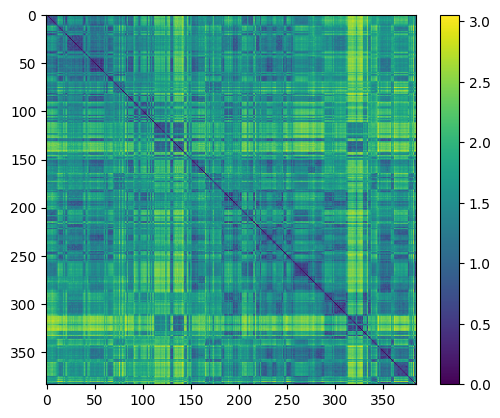

2.698327869258604


In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct,ExpSineSquared, ConstantKernel , WhiteKernel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from scipy.spatial.distance import cdist
from scipy.spatial.distance import squareform
from sklearn.svm import SVC

dataS_ = data.copy()
ind_ = data_['Cycle']==1
dataS_ = data_[ind_]

dataS_.sort_values(by='Treatment',inplace=True)
yS_ = dataS_['Treatment']
dataS_.drop(columns=col_sal,inplace=True)


sca_ = MinMaxScaler()
dataS_ = sca_.fit_transform(dataS_)
D_ = cdist(dataS_,dataS_)
D_ = 0.5*(D_+D_.T)
sig2_ = np.median(squareform(D_))**2
plt.imshow(D_)
plt.colorbar()
plt.show()
print(sig2_)


kernel0 = WhiteKernel(noise_level=1e-1, noise_level_bounds=(1e-01, 10))
kernel1 = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*RBF(length_scale=sig2_,length_scale_bounds=(0.01*sig2_, 10*sig2_))
kernel2 = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-05, 100000.0))
kernel3 = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*ExpSineSquared(length_scale=1.0, periodicity=1.0, length_scale_bounds=(1e-05, 100000.0), periodicity_bounds=(1e-05, 100000.0))

kernel = kernel1
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
#model_ = Pipeline([('scaler', MinMaxScaler()),
#                   ('svc', SVC(kernel='rbf',gamma=5/sig2_,C=1e3))])
#                  ('gpc', GaussianProcessClassifier(kernel=kernel,n_restarts_optimizer=20 ))])

#scores = cross_val_score(model_, dataS_, yS_, cv=sss,verbose=100)

#scores

In [ ]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier

import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', RandomForestClassifier())],#Pipeline2
        [('nor',MinMaxScaler()),
         ('cla', SVC())]#Pipeline3
      ]

parameters = [{
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline1 - hyperparametros
              },
              {
              'cla__n_estimators': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [2*sig2_,sig2_, 0.1*sig2_,0.01*sig2_ ]    #Pipeline2 - hyperparametros
             }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf']

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=sss,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(dataS_, yS_)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    #joblib.dump(models,filename+".pkl")

modelo 1/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 2/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 3/3
Fitting 5 folds for each of 20 candidates, totalling 100 fits


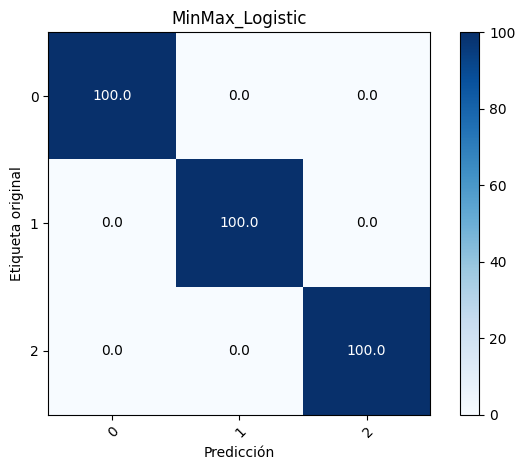

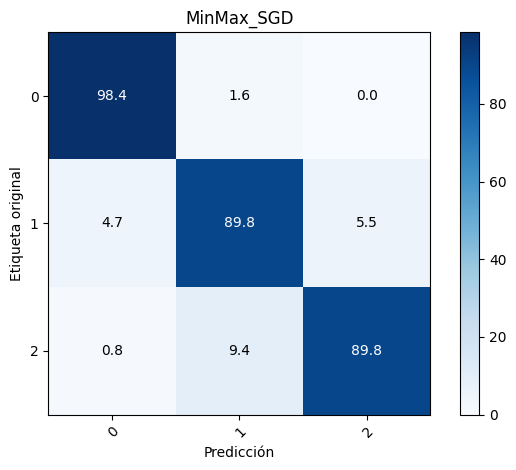

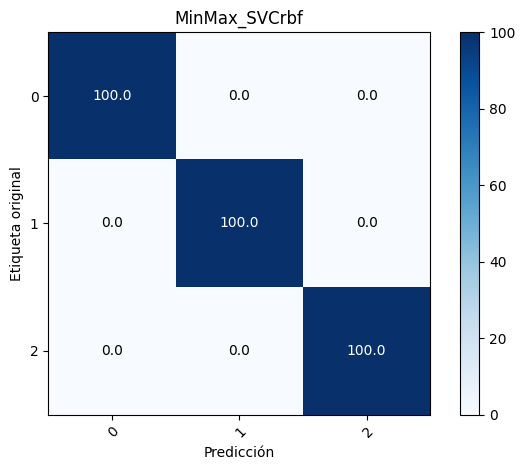

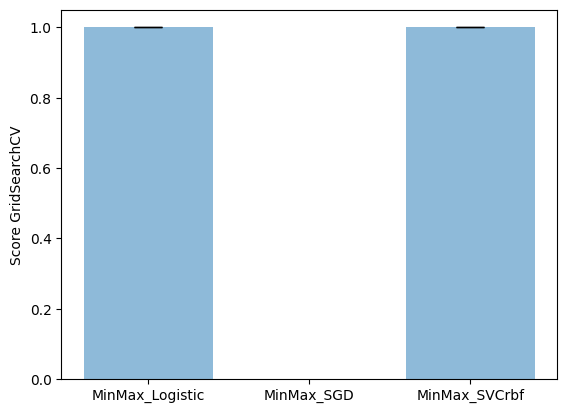

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf']
[[ 1. nan  1.]
 [ 0. nan  0.]]


In [ ]:
from sklearn.model_selection import cross_val_predict

#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  plot_confusion_matrix(
                          yS_, cross_val_predict(models[i].best_estimator_,dataS_, yS_,cv=10),
                          classes=['0','1','2'],
                          normalize=True,
                          title=label_models[i]
                          )
  plt.show()
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo


plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

In [ ]:
# def regressors (dataframe, target):
#   metric_dict = {'Features': [], 'model': [],  'MSE': [], 'MSE_STD': [], 'MAE': [], 'MAE_STD': [], 'R2': [], 'R2_STD': []}

#   list_dic = []
#   for i in range(1): #range(len(dataframe.columns)):
#     print(i)
#     Xw = dataframe.values
#     Y = target.values.ravel()
#   #   # cv = 1
#   #   # sca_ = MinMaxScaler()

#     print(Xw.shape)


#     #se crean listas de steps (pipelines)
#     steps=[[( 'nor', MinMaxScaler()),
#             ('reg1', RandomForestRegressor(random_state=30))],#Pipeline2
#             [('nor', MinMaxScaler()),
#             ('reg2', SVR())],#Pipeline3
#             [('nor', MinMaxScaler()),
#             ('reg3', ElasticNet(random_state=30))],#Pipeline4
#             ]
#     parameters = [
#                   {
#                     'reg1__n_estimators': [ 5, 10, 30, 50, 60,  100, 500],
#                     #'reg1__max_features': ['auto', 'sqrt', 'log2'],
#                     'reg1__max_depth' : [5,10, 20, 50],
#                     'reg1__criterion' :['squared_error', 'absolute_error'], #Pipeline2 - hyperparametros
#                   },
#                   {
#                     'reg2__kernel':['rbf'],
#                     'reg2__C': [1,10, 100, 1e3, 10e3],
#                     'reg2__gamma': [ 1e-4, 1e-3, 1e-2, 1e-1],    #Pipeline3 - hyperparametros
#                     'reg2__epsilon': [ 0.0109, 0.14, 0.05, 0.2, 2] #[1e-3, 0.01, 0.1, 1], #, 0.05,0.2, 2],
#                   },
#                   {
#                       "reg3__max_iter": [1, 5, 10, 20],
#                       "reg3__alpha": [0.0001, 0.001, 0.01, 0.1],
#                       "reg3__l1_ratio": np.arange(0.0, 1.0, 0.1)}
#                 ]


#     scoring =  {'r2': 'r2', 'mse': 'neg_mean_squared_error', 'mae': 'neg_mean_absolute_error'}

#     label_models = ['MinMax_randomForest', 'MinMax_SVRrbf','MinMax_elasticnet']

#     models = []
#     # filename = 'results/regression_models'
#     for i in range(len(steps)): # recorrer modelos según lista pipeline
#         #print('modelo %d/%d' % (i+1,len(steps)))
#         grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1, cv=ShuffleSplit(test_size=0.20, n_splits=3),
#                                     scoring= scoring, refit='mae',verbose=0)#gridsearch para modelo i
#         grid_search.fit(Xw, Y)
#         #mejor modelo entrenado
#         models += [grid_search] #guardar modelos
#       # joblib.dump(models,filename+".pkl")

#     for i in range(len(models)):
#         metric_dict['Features'].append(Xw.shape[1])
#         metric_dict['model'].append(label_models[i])
#         ind = models[i].cv_results_['mean_test_r2'].argmax()#se determina el mejor r2 de clasificación
#         metric_dict['R2'].append(models[i].cv_results_['mean_test_r2'][ind])
#         metric_dict['R2_STD'].append(models[i].cv_results_['std_test_r2'][ind])

#         ind = models[i].cv_results_['mean_test_mse'].argmax()#se determina el mejor mse de clasificación
#         metric_dict['MSE'].append(models[i].cv_results_['mean_test_mse'][ind]*-1 )
#         metric_dict['MSE_STD'].append(models[i].cv_results_['std_test_mse'][ind])

#         ind = models[i].cv_results_['mean_test_mae'].argmax()#se determina el mejor mae de clasificación
#         metric_dict['MAE'].append(models[i].cv_results_['mean_test_mae'][ind]*-1)
#         metric_dict['MAE_STD'].append(models[i].cv_results_['std_test_mae'][ind])
#         if i>=2:
#           print(models[i].cv_results_['mean_test_mae'][ind])
#     metric_df = pd.DataFrame(metric_dict)
#     list_dic +=  [metric_dict]



#   return metric_df

In [ ]:
# from sklearn.manifold import TSNE




# df = Xdata
# col_sal = ['Soil_moisture' , 'LWP_pd', 'LWP_md',  'CWC_cal',  'LAI_cep', 'LAI_cal', 'CWC_cept', 'LAI_cep', 'Dry_biomass']
# targets = df[col_sal]
# target = targets[['Dry_biomass' ]]
# df.drop(columns=col_sal,inplace=True)
# #print(df.columns)
# #metric_df = regressors(df.iloc[:, 3:40], target)

# #metric_df.to_csv("/content/drive/Shareddrives/GCPDS/Arroz/index_relevance/results_TSNE_"+Varieties[i]+"_STAGE" + str(j+ 1)+".csv")

In [ ]:
# #entrenar gpr
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF, DotProduct,ExpSineSquared, ConstantKernel
# import matplotlib

# mmax = MinMaxScaler()
# X_train, X_test, y_train, y_test = train_test_split(
#    mmax.fit_transform(df.iloc[:, 3:40]), target, test_size=0.3, random_state=42)
# #definir gpr
# alpha = 45 #10*(1/np.var(target.values))#1e-5
# #kernel
# kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*RBF(length_scale=1,length_scale_bounds=(1e-1, 10.0))+ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-05, 100000.0))+ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*ExpSineSquared(length_scale=1.0, periodicity=1.0, length_scale_bounds=(1e-05, 100000.0), periodicity_bounds=(1e-05, 100000.0))
# #crear gpr
# gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, random_state=0)#crear objeto gpr

# gpr.fit(X_train, y_train.values.ravel()) #entrenar GPR en train



In [ ]:
# gpr.score(X_test, y_test)

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=41230415a0ef3e7a209f4b4354fee87c43f2bf628177158307ffae8fdb5c6779
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=40177dbfe44683f48b77d93a668a47d04d7f85cd33310659341d01f30a6d5cc0
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


# Biplot 2D local

In [ ]:
from scipy.spatial.distance import cdist, squareform
import matplotlib
from umap import UMAP

# Objeto para guardar resultados:
class GMDOutput:
    pass

#centering kernels
class lnkbp():
  def __init__(self, X, labels = None, perplexity = None, red = 'tsne', sca = 'minmax',random_seed=123):
        self.X = X.copy()
        self.columns_= self.X.columns
        self.labels = labels
        if perplexity==None:
          perplexity = round(np.sqrt(X.shape[0]))
        self.perplexity = perplexity
        self.random_seed = random_seed
        self.red = red
        self.sca = sca

  def sca_(self,X,feature_range=(0,1)):
    if self.sca == 'minmax':
      sca_ = MinMaxScaler(feature_range=feature_range)
    return sca_.fit_transform(X)

  def red_(self,X):
    if self.red == 'tsne':
      self.red_ = TSNE(n_components = 2, perplexity = self.perplexity, random_state=self.random_seed)
    elif self.red == 'pca':
      self.red_ = PCA(n_components = 2, random_state=self.random_seed)
    elif self.red == 'umap' :
      self.red_ = UMAP(n_components = 2, n_neighbors = round(np.sqrt(X.shape[0])),min_dist =0.9,random_state=self.random_seed)
    else:
      self.red_ = TSNE(n_components = 2, perplexity = self.perplexity, random_state=self.random_seed)

    return self.sca_(self.red_.fit_transform(X))

  def krbf(self,X):
    D_ = cdist(X,X)
    sig2 = 0.5*np.median(squareform(D_))
    return np.exp(-D_**2/sig2)

  def kcen(self, K):
    n = K.shape[0]
    one_n = np.ones((n,1))
    H = np.eye(n) - (1 / n) * np.dot(one_n, one_n.T)
    return (H.dot(K)).dot(H)

  #input features laplacian score
  def laplacian_score(self,X,K, tol=1e-10):
      Dl = np.diag(K.sum(axis=1)+tol)
      L = Dl - K # unnormalized
      #L = np.eye(Kk.shape[0])-np.diag((np.diag(Dl)**(-0.5))).dot(Kk).dot(np.diag((np.diag(Dl)**(-0.5))))
      X_ = X - np.kron(np.ones((1,Dl.shape[0])),((X.T).dot(Dl)).dot(np.ones((Dl.shape[0],1)))/(np.sum(np.diag(Dl)))).T
      return np.diag((X_.T).dot(L).dot(X_))/np.diag((X_.T).dot(Dl).dot(X_))

  def lnkbp_(self):
      self.X_ = self.sca_(self.X) #scaler X
      self.Z = self.red_(self.X_) #red
      self.localbp_(self.X_)
      self.X['P1'] = self.Z[:,0] #add red to pd
      self.X['P2'] = self.Z[:,1]
      self.KX = self.krbf(self.X_) #kernel X samples
      self.KXF = self.krbf(self.X_.T) #kernel X features
      self.KZ = self.krbf(self.Z) # kernel Z samples

      self.lsX = self.laplacian_score(self.X_,self.KX) #features KX
      self.lsZ = self.laplacian_score(self.X_,self.KZ) #features KZ

      return self

  def localbp_(self,X_):
    self.C = np.unique(self.labels)
    N = X_.shape[0]
    self.muZ = np.zeros((len(self.C),2))
    redl = PCA(n_components=2,random_state=self.random_seed)
    self.lpca = []
    for c,vc in enumerate(self.C):
      self.muZ[c] = np.mean(self.Z[self.labels==vc],axis=0)
      ind_ = self.labels==vc

      self.lpca += [self.sca_(redl.fit_transform(X_[ind_]))]#- np.kron(self.muZ[c],np.ones((sum(self.labels==vc),1)))]
      self.lpca[c] = self.lpca[c] - self.lpca[c].mean(axis=0)
      self.lpca[c] = self.lpca[c] + self.muZ[c]

    return self



  #======================= funciones GMD ===========================================

  # Funcion get_uv_
  def get_uv(self, X, H, Q, u_0, v_0):#H N x N, Q P x P
      u = X @ Q @ v_0 / (np.sqrt(v_0.T @ Q.T @ X.T @ H @ X @ Q @ v_0))
      v = X.T @ H @ u / (np.sqrt(u.T @ H.T @ X @ Q @ X.T @ H @ u))
      return {'u': u, 'v': v}
  # Funcion para hacer fit:
  def GMD(self, X, H, Q, K):
      error_vec = []
      n, p = X.shape
      # Output matrices/vectors
      U = np.zeros((n, K))
      V = np.zeros((p, K))
      D = np.zeros(K)
      X_0 = X
      u_0 = np.concatenate(([1], np.zeros(n-1)))
      v_0 = np.concatenate(([1], np.zeros(p-1)))
      for iter in range(1, K + 1):
          error = 1
          while error > 1e-14:
              temp_uv = self.get_uv(X_0, H, Q, u_0, v_0)
              u = temp_uv['u']
              v = temp_uv['v']
              error = np.linalg.norm(u - u_0, ord=2) + np.linalg.norm(v - v_0, ord=2)
              error_vec += [error]
              u_0 = u
              v_0 = v
          U[:, iter - 1] = u
          V[:, iter - 1] = v
          d = u.T @ H @ X_0 @ Q @ v
          D[iter - 1] = d
          X_0 = X_0 - (u[:, np.newaxis]*d)@v[np.newaxis, :]
      # plt.plot(error_vec)
      # plt.xlabel('iterations')
      # plt.ylabel('error grater than 1e-5')
      gmd_output = GMDOutput()
      gmd_output.U = U
      gmd_output.V = V
      gmd_output.D = D
      gmd_output.H = H
      gmd_output.Q = Q
      gmd_output.X = X
      return gmd_output


  def biplot_gmd_body(self, fit, index=None, names=None, sample_col='grey50', sample_pch=19, arrow_col='orange', arrow_cex=1):
    U = fit.U
    D = fit.D
    V = fit.V
    U = U[:, np.argsort(D)[::-1]]
    V = V[:, np.argsort(D)[::-1]]
    k1 = np.argsort(D)[::-1][0]
    k2 = np.argsort(D)[::-1][1]
    D = np.sort(D)[::-1]
    eta = U @ np.diag(D)
    max_xlab = np.max(np.abs(eta[:, 0]))
    max_ylab = np.max(np.abs(eta[:, 1]))
    plt.figure(figsize=(8, 6))
    #plt.scatter(eta[:, 0], eta[:, 1],  c=sample_col)
    sns.scatterplot(x=eta[:, 0],
                y= eta[:, 1],
                hue =sample_col, palette = "viridis")
    plt.xlabel(f'PC{k1}', fontsize=16)
    plt.ylabel(f'PC{k2}', fontsize=16)
    plt.xlim(-1.1 * max_xlab, 1.1 * max_xlab+1)
    plt.ylim(-1.1 * max_ylab, 1.1 * max_ylab+1)
    # calculate coordinates

    Q = fit.Q
    V_plot = Q @ V
    arrow_x = V_plot[:, 0]
    arrow_y = V_plot[:, 1]
    max_xarrow = np.max(np.abs(arrow_x))
    max_yarrow = np.max(np.abs(arrow_y))
    xratio = max_xarrow / max_xlab
    yratio = max_yarrow / max_ylab

    xaxp = np.linspace(-max_xlab, max_xlab, num=5)
    yaxp = np.linspace(-max_ylab, max_ylab, num=5)

    xlab_arrow = xaxp * xratio
    ylab_arrow = yaxp * yratio
    print(f"len of V = {len(V)}")
    print(f"len of x arrow = {len(arrow_x)}")
    print(f"len of y arrow = {len(arrow_y)}")
    print(f"len of names = {len(names)}")
    iter = 0
    for i in index:

        #arrow_length = np.sqrt(arrow_x[i] ** 2 + arrow_y[i] ** 2)
        #if arrow_length >= 0.1:
        plt.arrow(0, 0, arrow_x[i] / xratio, arrow_y[i] / yratio, head_width=0.1, head_length=0.1,  color=arrow_col)
        if names is not None:
         # print(f"i = {i}")
          plt.text(arrow_x[i]/ xratio, arrow_y[i] / yratio * 1.06, names[iter], fontsize=17, color='black')
          iter += 1

    # Add new axes
    plt.xticks(xaxp, labels=[f'{round(val, 2)}' for val in xlab_arrow], fontsize=16)
    plt.yticks(yaxp, labels=[f'{round(val, 2)}' for val in ylab_arrow], fontsize=16)
    plt.gca().tick_params(axis='both', which='both', length=0)
    plt.legend(loc='upper left', title= sample_col.name)
    plt.legend(fontsize=16)
    #plt.colorbar()

    plt.show()

  #===================== Fin funciones GMD ============================================

  def plot_lnkbp_(self,hue, c, figsize = (25,10)):
    fig, ax = plt.subplots(2,3,figsize=figsize)

    #scatter
    kdeplot(data=self.X, x='P1', y='P2',hue=hue, ax=ax[1,0], levels=3)
    self.X.plot(kind='scatter',x='P1',y='P2',ax=ax[1,0],c=c,cmap='jet',legend=False)

    #scatter local bp
    cmap_ = matplotlib.cm.jet(np.linspace(0,1,len(self.C)))
    for c,vc in enumerate(self.C):
        ax[1,1].scatter(self.muZ[c,0],self.muZ[c,1],marker='d',s=100,c=cmap_[c])
        ax[1,1].scatter(self.lpca[c][:,0],self.lpca[c][:,1],c=cmap_[c])

    #kernels
    vmin = min(self.KX.ravel().min(),self.KZ.ravel().min(),self.KXF.ravel().min() )
    vmax = max(self.KX.ravel().max(),self.KZ.ravel().max(),self.KXF.ravel().max() )
    ax[0,0].imshow(self.KX,vmin=vmin,vmax=vmax, cmap='Reds')
    ax[0,0].set_xlabel('Samples')
    ax[0,0].set_ylabel('Samples')
    ax[0,1].imshow(self.KZ,vmin=vmin,vmax=vmax, cmap='Reds')
    ax[0,1].set_xlabel('Samples')
    ax[0,1].set_ylabel('Samples')


    im_ = ax[0,2].imshow(self.KXF,vmin=vmin,vmax=vmax, cmap='Reds')
    ax[0,2].set_xlabel('Features')
    ax[0,2].set_ylabel('Features')
    #colorbar
    cax = fig.add_axes([0.92, 0.5, 0.01, 0.4])
    norm = matplotlib.colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm,cax=cax)

    #feature relevance
    ax[1,2].bar(np.arange(len(self.lsZ)),self.lsZ,label='LS_Z')#red kernel
    ax[1,2].bar(np.arange(len(self.lsX)),self.lsX,bottom=self.lsZ,label='LS_X')#input kernel

    ax[1,2].set_xticks(ticks=np.arange(len(self.lsX)),labels=self.columns_,rotation=90)
    ax[1,2].legend()
    ax[1,2].set_ylabel('Laplacian Score')
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    #plt.tight_layout()
    plt.show()


  def affine_transformM(self, parameters, array_A):
    # Apply affine transformation to array_A with parameters
    N = array_A.shape[0] #N x 2 array
    scale = parameters[0]
    rotation = parameters[1]
    translation = parameters[2:]
    transformation_matrix = np.array([
        [scale * np.cos(rotation), -scale * np.sin(rotation), translation[0]],
        [scale * np.sin(rotation), scale * np.cos(rotation), translation[1]],
    ]) # 2 x 3 transformation matrix
    transformed_A = np.dot(transformation_matrix, np.c_[array_A,np.ones((N,1))].T)
    return transformed_A.T

  def registration_errorM(self, parameters, array_A, array_B): # N x 2 arrays
    # Compute the registration error (sum of squared differences)
    transformed_A = self.affine_transformM(parameters, array_A)
    N = array_A.shape[0]
    error = (1/N)*np.linalg.norm(transformed_A - array_B,'fro')
    return error

    return

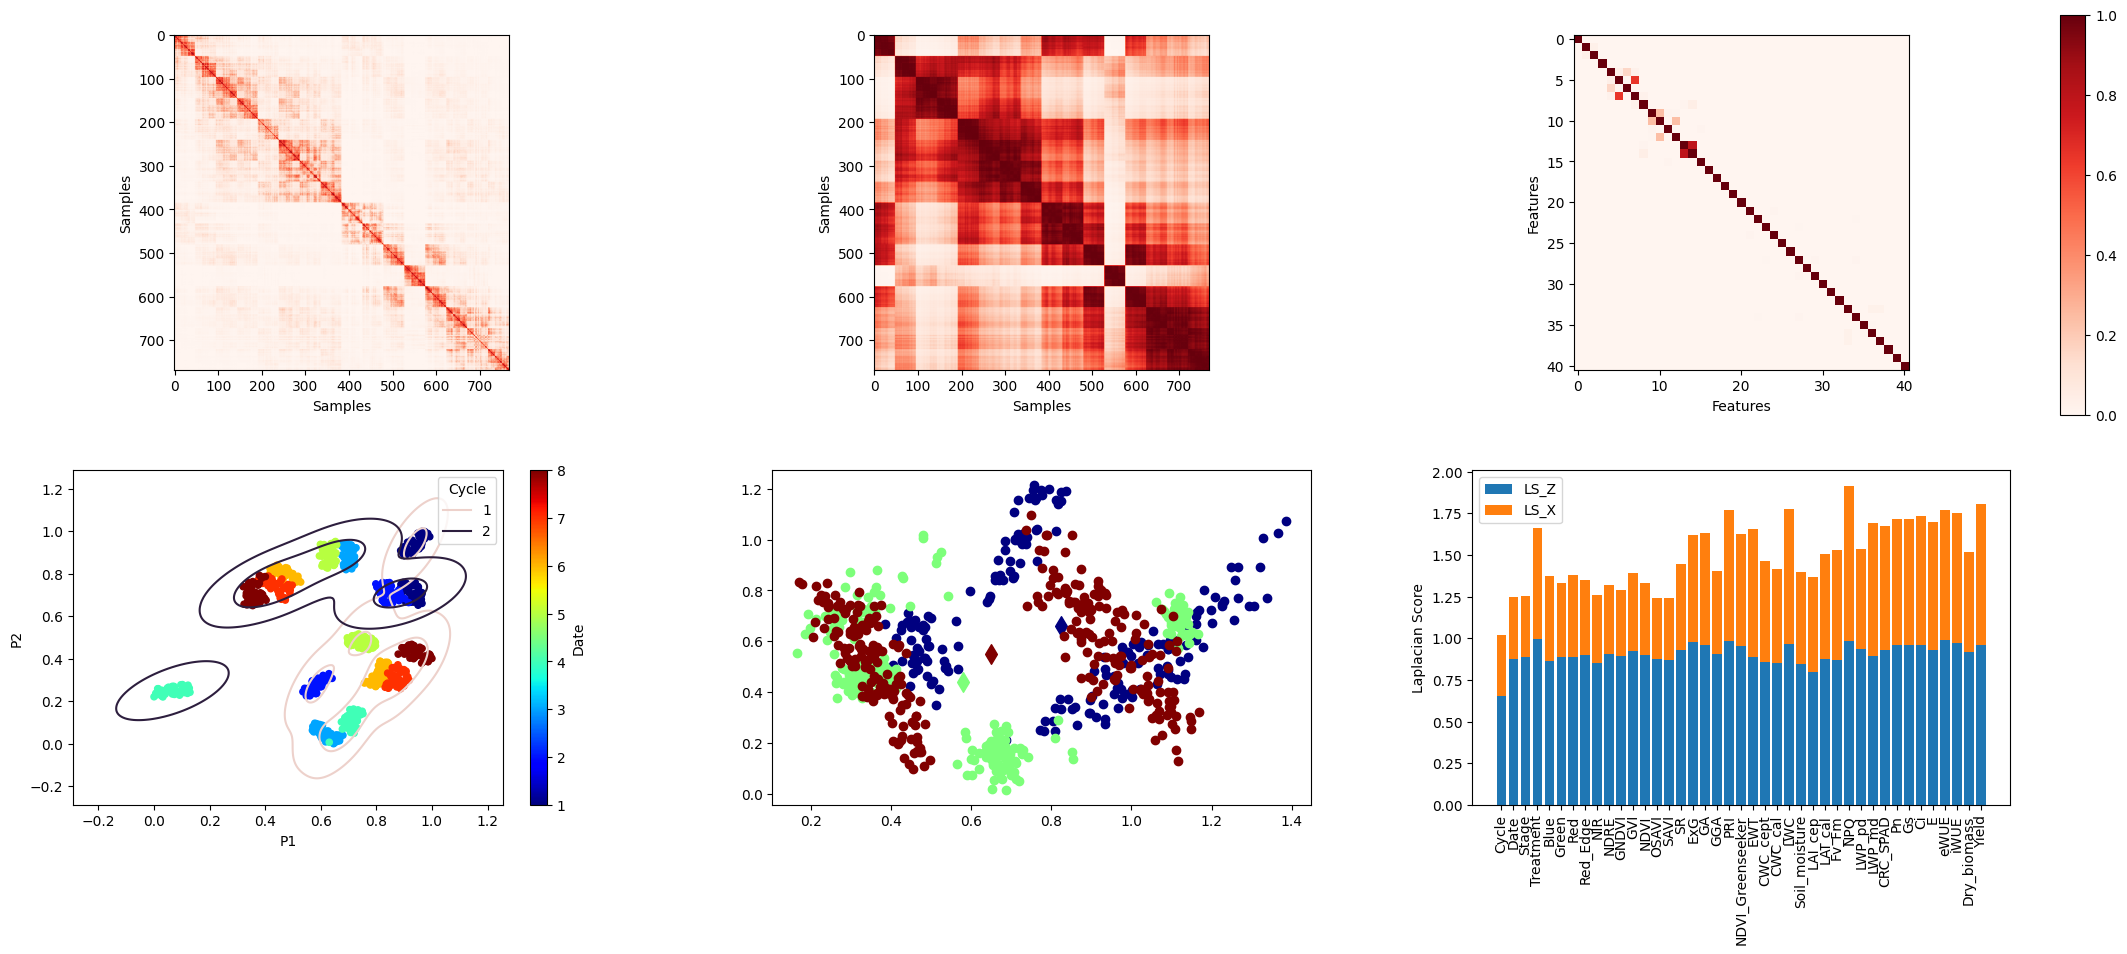

In [ ]:
databp = data_.copy()
rice_ = lnkbp(databp,labels=databp['Stage'].values,perplexity=None,red = 'umap') #class instance
rice_.lnkbp_()
rice_.plot_lnkbp_(hue='Cycle',c='Date')

#Prueba GMD

len of V = 41
len of x arrow = 41
len of y arrow = 41
len of names = 5


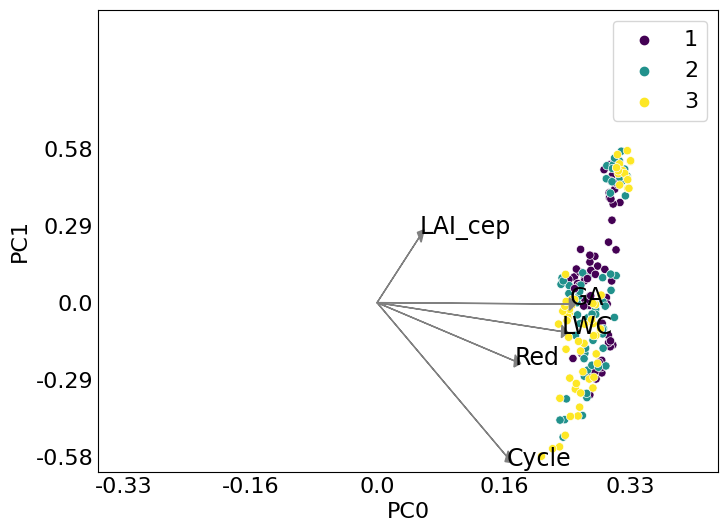

len of V = 41
len of x arrow = 41
len of y arrow = 41
len of names = 5


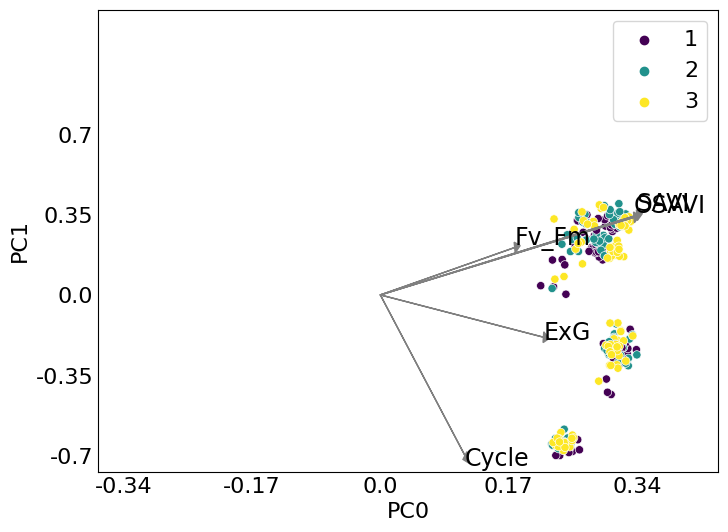

len of V = 41
len of x arrow = 41
len of y arrow = 41
len of names = 5


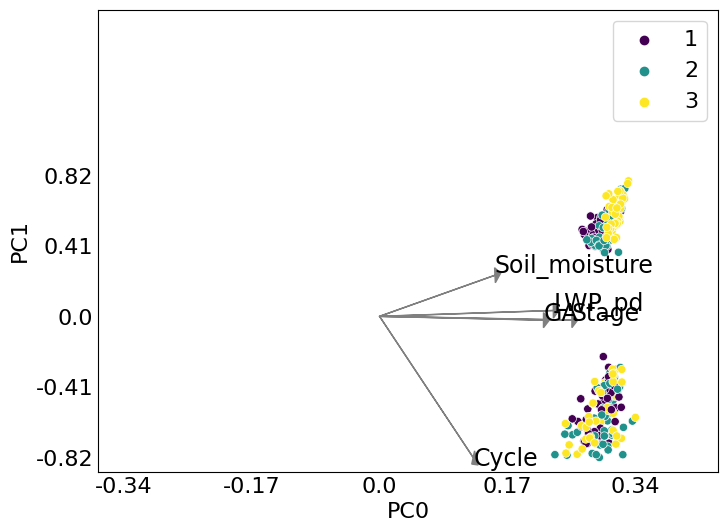

In [ ]:
KZ = rice_.KZ  #kernel rbf tsne reduction
KQ = rice_.KXF #kernel features
Ck = len(np.unique(databp['Stage'].values)) # stages = 3
cmap_ = cm.jet(np.linspace(0,1,Ck))  #colormap


for i, v in enumerate(np.unique(databp['Stage'].values)):
  ind_ = databp['Stage'] == v  # iterate by stage
  #print(ind_)
  KZ1 = KZ[ind_]
  KZ1 = KZ1[:,ind_]
  KQ1 = KQ

  result = rice_.GMD(rice_.X_[ind_], KZ1, KQ1, K=2)
  # Organizar variables mas significativas (indices):
  result.order = np.argsort(np.sum(result.V[:, :2]**2, axis=1))[::-1]
  # Extraer las 3 primeras para biplot:
  plot_index = result.order[:5]
  # Extraer nombres de las variables a mostrar:
  names = databp.columns
  plot_names = [names[i] for i in plot_index]

  # bi - plot
  rice_.biplot_gmd_body(result,
                index=plot_index,
                names=plot_names,
                sample_col= databp[ind_]['Treatment'],
                sample_pch=None,
                arrow_col='gray')




In [ ]:
import numpy as np
from scipy.optimize import minimize

def affine_transform(parameters, vector_A):
    # Apply affine transformation to vector_A with parameters
    scale = parameters[0]
    rotation = parameters[1]
    translation = parameters[2:]
    transformation_matrix = np.array([
        [scale * np.cos(rotation), -scale * np.sin(rotation), translation[0]],
        [scale * np.sin(rotation), scale * np.cos(rotation), translation[1]],
    ])
    transformed_A = np.dot(transformation_matrix, np.r_[vector_A,1])
    return transformed_A

def registration_error(parameters, vector_A, vector_B):
    # Compute the registration error (sum of squared differences)
    transformed_A = affine_transform(parameters, vector_A)
    error = np.sum((transformed_A - vector_B) ** 2)
    return error

# Example vectors A and B
vector_A = np.array([0.3, -0.4])
vector_B = np.array([0, 1])

# Initial guess for optimization parameters (scale, rotation, translation)
initial_parameters = np.array([1.0, 0.0, 0, 0])

# Perform the optimization to find the best affine transformation
result = minimize(registration_error, initial_parameters,
                  args=(vector_A,vector_B),method='Nelder-Mead')

# Get the optimized transformation parameters
optimized_parameters = result.x

# Apply the optimized transformation to vector A
registered_A = affine_transform(optimized_parameters, vector_A)

print("Original Vector A:", vector_A)
print("Vector B:", vector_B)
print("Registered Vector A:", registered_A)
print("Optimized Parameters (scale, rotation, translation):", optimized_parameters)

Original Vector A: [ 0.3 -0.4]
Vector B: [0 1]
Registered Vector A: [-1.72350815e-05  9.99993305e-01]
Optimized Parameters (scale, rotation, translation): [-1.04755954 -0.4380517   0.10683758  0.48722894]


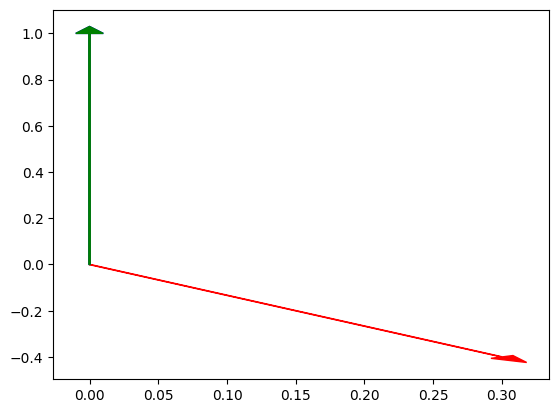

In [ ]:
plt.arrow(0,0,vector_A[0],vector_A[1],head_width=0.02,color='r')
plt.arrow(0,0,vector_B[0],vector_B[1],head_width=0.02,color='b')
plt.arrow(0,0,registered_A[0],registered_A[1],head_width=0.02,color='g')
plt.show()

In [ ]:

from sklearn.cluster import DBSCAN


def affine_transformM(parameters, array_A):
    # Apply affine transformation to array_A with parameters
    N = array_A.shape[0] #N x 2 array
    scale = parameters[0]
    rotation = parameters[1]
    translation = parameters[2:]
    transformation_matrix = np.array([
        [scale * np.cos(rotation), -scale * np.sin(rotation), translation[0]],
        [scale * np.sin(rotation), scale * np.cos(rotation), translation[1]],
    ]) # 2 x 3 transformation matrix
    transformed_A = np.dot(transformation_matrix, np.c_[array_A,np.ones((N,1))].T)
    return transformed_A.T

def registration_errorM(parameters, array_A, array_B): # N x 2 arrays
    # Compute the registration error (sum of squared differences)
    transformed_A = affine_transformM(parameters, array_A)
    N = array_A.shape[0]
    error = (1/N)*np.linalg.norm(transformed_A - array_B,'fro')
    return error


def plot_biplot(Z,V,ax,c='r',s=10,nval=10,marker='.'):
    ax.scatter(Z[:,0],Z[:,1],c=c,s=s,marker=marker)
    P = V.shape[0]
    mu = Z.mean(axis=0)
    V = V /np.linalg.norm(V,axis=0)
    val = np.linalg.norm(abs(V),axis=1)
    indv = np.argsort(val)[::-1]
    #print(indv)
    if nval > 0:
       for i in range(nval):
           ax.arrow(mu[0],mu[1],V[indv[i],0],V[indv[i],1],head_width=0.02,color=c)

    return val

def clustering(Z, eps_=None,per_=5): #N x 2 array
    if eps_ == None:
       eps_=np.percentile(squareform(cdist(Z, Z)),q=per_)
    clus = DBSCAN(eps=eps_)
    clus.fit(Z)
    return clus.labels_

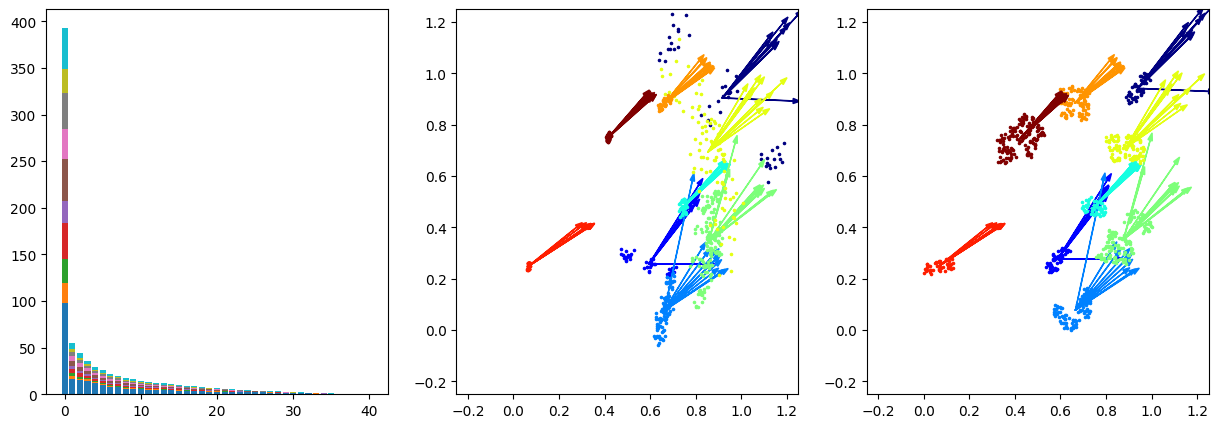

array([0.2722767 , 0.32784409, 0.2722767 , 0.25539036, 0.24238226,
       0.26358265, 0.28804102, 0.25940846, 0.16090925, 0.26026248,
       0.23629013, 0.2003272 , 0.24536195, 0.20310916, 0.19309673,
       0.13741969, 0.34574422, 0.3589879 , 0.44248799, 0.16795498,
       0.21944904, 0.20445035, 0.18424533, 0.08446543, 0.21221773,
       0.12720049, 0.19896742, 0.03679458, 0.140772  , 0.02156469,
       0.24236416, 0.11726592, 0.18337679, 0.28364826, 0.05976404,
       0.1058905 , 0.13396148, 0.24337899, 0.11890208, 0.1219322 ,
       0.14100542])

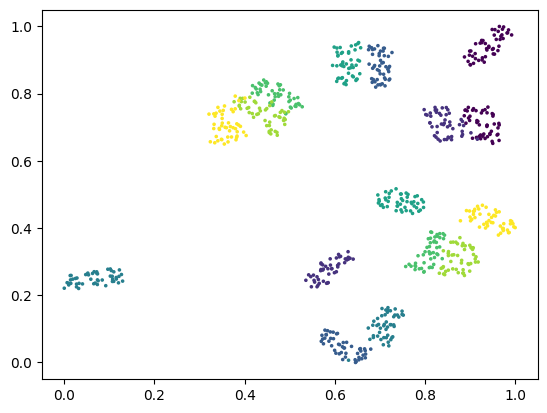

In [ ]:
KZ = rice_.KZ  #kernel rbf tsne reduction
tar_ = clustering(rice_.Z, per_=5)#databp['Date'].values
Ck = len(np.unique(tar_))
cmap_ = cm.jet(np.linspace(0,1,Ck))  #colormap
indv_ = np.zeros((rice_.X_.shape[1],Ck))
a_ = np.zeros((Ck))
Ug, Sg, Vhg  = np.linalg.svd(rice_.X_) #svd scaled data
U = []
Vh = []
S = np.zeros((Sg.shape[0],Ck)) # S matrix with the form of sg rows  41 x 3
nval = 10
fig, ax = plt.subplots(1,3,figsize=(15,5))
bottom = np.zeros(S.shape[0]) #vector of zeros size 41

p = ax[0].bar(np.arange(Sg.shape[0]), Sg, label='g',bottom=bottom) # plotting singular values
bottom += Sg
for i, v in enumerate(np.unique(tar_)):
  ind_ = tar_ == v  # iterate by stage
  KZ1 = KZ[ind_]
  KZ1 = KZ1[:,ind_]
  a_[i] = np.sum(KZ1.sum(axis=1))
  Uc, Sc, Vhc  = np.linalg.svd(rice_.X_[ind_]) #extract svd by stage #GMD Jenny
  #Sc = Sc/Sg
  U += [Uc] #grouped
  S[:,i] = Sc #grouped

  Vh += [Vhc[:2,:].T] #grouped
  p = ax[0].bar(np.arange(Sc.shape[0]), Sc, label=v,bottom=bottom) #plot every bar
  bottom += Sc #why this
  Zc = rice_.X_[ind_].dot(Vhc.T[:,:2])
  Vhc = Vhc.T.dot(np.diag(Sg**(0.005))).T  #affine transformation tsne vs local pca-svd biplot
  #Initial guess for optimization parameters (scale, rotation, translation)
  initial_parameters = np.array([1.0, 0.0, 0.0, 0.0])
  # Perform the optimization to find the best affine transformation rotando bases de cada espacio?
  result = minimize(registration_errorM, initial_parameters,
                  args=(Zc,rice_.Z[ind_]),method='Nelder-Mead')

  #print(result.x)
  optimized_parameters = result.x
  ZcA = affine_transformM(optimized_parameters, Zc) #transforma puntos del cluster
  VA = affine_transformM(optimized_parameters, (Vhc[:2,:].T).dot(np.diag(Sc[:2])))#transform vec flechas del cluster
  #plot_biplot(Zc,Vhc[:2,:].T,ax=ax[1],c=cmap_[i],s=2)
  indv_[:,i] = plot_biplot(ZcA,VA,ax=ax[1],c=cmap_[i],nval=nval)#X embedded by local biplot svd
  indcc = plot_biplot(rice_.Z[ind_],VA,ax=ax[2],c=cmap_[i],nval=nval) #self.Z -> x embeebed by tsne

ax[1].set_xlim([-0.25,1.25])
ax[1].set_ylim([-0.25,1.25])

ax[2].set_xlim([-0.25,1.25])
ax[2].set_ylim([-0.25,1.25])

plt.show()

fig,ax_ = plt.subplots(1)
plot_biplot(rice_.Z,Vhc[:2,:].T,ax=ax_,c=rice_.X['Date'],nval=0)

In [ ]:
Vhc

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.15153875,  0.85913794],
       [ 0.15256331, -0.03702196],
       [ 0.17192436, -0.10095986],
       [ 0.15556604,  0.01325413],
       [ 0.15377985, -0.08840137],
       [ 0.10784115, -0.13320581],
       [ 0.08909033, -0.11404007],
       [ 0.11689418, -0.08763472],
       [ 0.04555138, -0.05549656],
       [ 0.14379295, -0.14022578],
       [ 0.14645382, -0.15014359],
       [ 0.13403851, -0.15582831],
       [ 0.02884868, -0.05761899],
       [ 0.15832118, -0.05507424],
       [ 0.28791955,  0.04878419],
       [ 0.23580329,  0.03153189],
       [ 0.20174856,  0.08212708],
       [ 0.2053104 , -0.05953222],
       [ 0.18021098,  0.00991651],
       [ 0.02187245, -0.00761468],
       [ 0.02138055, -0.02543131],
       [ 0.24809724,  0.03105894],
       [ 0.1863327 ,  0.06228945],
       [ 0.04592617, -0.00848118],
       [ 0.01155027, -0.00840239],
       [ 0.19019069,

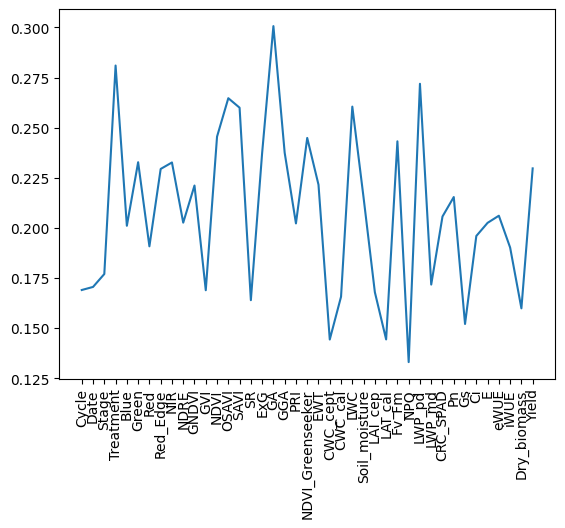

In [ ]:
#plt.hist(indv_[:nval].ravel(),bins=indv_.shape[0])
plt.plot(indv_.mean(axis=1)) #[:nval].ravel(),bins=indv_.shape[0])

plt.xticks(np.arange(indv_.shape[0]),
         rice_.X.columns[:-2],rotation=90)

plt.show()